<a href="https://colab.research.google.com/github/diviramon/BASSic/blob/master/PanoGAN_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Mar 12 23:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom
!pip install pytorch-msssim

     |████████████████████████████████| 1.9MB 5.1MB/s 


# Import Libraries

In [1]:
DIM = 64
OUTPUT_DIM = DIM*DIM*1

import shutil
import os
import cv2
import re
import random
from skimage.io import imread 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import pandas as pd
from torch import nn
from torch.autograd import grad
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split, ConcatDataset

from collections import OrderedDict
import time
from tqdm import tqdm

from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils

from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab.patches import cv2_imshow
import pydicom as dcm
from skimage import io, exposure
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

from torch.utils.data import DataLoader
from torch import autograd
from torchvision.utils import save_image
from torch.utils.data import sampler
from argparse import ArgumentParser
from sklearn import metrics

# Make Folders

In [5]:
!rm -r sample_data/
!mkdir data
!mkdir data/train
!mkdir data/train/healthy
!mkdir data/valid
!mkdir data/valid/healthy
!mkdir data/valid/nodule
!mkdir data/test/
!mkdir data/test/healthy
!mkdir data/test/nodule
!mkdir data/patients/
!mkdir output/
!mkdir output/patients/

!mkdir encoder

# Read Image Functions

In [6]:
def read_indiana(file_name, cxr_path, mask_path):
  
  dcm_filename = file_name[3:-4] + '.dcm'

  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255

  # Read in DICOM 
  ds = dcm.dcmread(os.path.join(cxr_path, dcm_filename))
  cxr = ds.pixel_array
  #print(ds.PhotometricInterpretation)
  #cxr = dcm.pixel_data_handlers.util.apply_voi_lut(cxr, ds, index=0)
  cxr = cv2.resize(cxr, (1024, 1024))
  if ds.PhotometricInterpretation == 'MONOCHROME1':
    cxr = 1.0 - cxr * 1./cxr.max()
  else:
    cxr = cxr * 1. / cxr.max()
  cxr = exposure.equalize_adapthist(cxr,kernel_size=128)
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)

  return mask, cxr

In [7]:
def read_nih(file_name, cxr_path, mask_path):
  
  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255
  
  # Read in PNG
  cxr = cv2.imread(os.path.join(cxr_path, file_name))
  cxr = cv2.cvtColor(cxr, cv2.COLOR_BGR2GRAY)
  cxr = cv2.resize(cxr, (1024, 1024)) 
  cxr = cxr * 1./cxr.max()
  cxr = exposure.equalize_adapthist(cxr,kernel_size=128)
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)

  return mask, cxr

In [171]:
def read_jsrt(file_name, cxr_path, mask_path):

  # Pre-process mask
  mask = cv2.imread(os.path.join(mask_path, file_name))
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_NEAREST)
  mask = (mask > 127) * 255

  # Read in IMG
  # fname = file_name[:-4] + '.IMG'
  # cxr = 1.0 - np.fromfile(os.path.join(cxr_path, fname), dtype='>u2').reshape((2048, 2048)) * 1. / 4095
  cxr = cv2.imread(os.path.join(cxr_path, file_name))
  cxr = cv2.cvtColor(cxr, cv2.COLOR_BGR2GRAY)
  cxr = cv2.resize(cxr, (1024, 1024)) 
  cxr = cxr * 1./cxr.max()
  cxr = exposure.equalize_adapthist(cxr,kernel_size=128)
  normalizedImg = np.zeros((1024, 1024))
  cxr = cv2.normalize(cxr,  normalizedImg, 0, 255, cv2.NORM_MINMAX)

  return mask, cxr

In [172]:
def crop_patches(image, mask, total_patches, box, image_name, dataset, svpath):
  if dataset == 'indiana':
    patch_extractor = ExtractPatches(image_name, image, mask, box, DIM, DIM//2, dataset, svpath)
  else:
    patch_extractor = ExtractPatches(image_name, image, mask, box, DIM, DIM//4, dataset, svpath)
  
  lung_area = np.count_nonzero(mask)
  patches = patch_extractor.extract_all_patches()
  total_patches = total_patches + patches

  return total_patches

In [173]:
class ExtractPatches:
    def __init__(self, image_name, image, mask, bbox, patchSize, stride, dataset, out_path):
        self.image = image
        self.out_path = out_path
        self.dataset = dataset
        self.bbox = bbox
        self.annotated = np.copy(image) 
        self.reconstructed = np.empty(image.shape)
        self.reconstructed[:] = np.nan
        self.image_name = image_name
        self.patchSize = patchSize
        self.stride = stride
        self.mask = mask

    def draw_single_patches(self, coords, patch):
      y1 = coords[0] * self.stride
      x1 = coords[1] * self.stride
      y2 = coords[0] * self.stride + self.patchSize
      x2 = coords[1] * self.stride + self.patchSize
      self.annotated = cv2.rectangle(self.annotated,(x1,y1), (x2,y2), (0, 0, 255))
      self.reconstructed[y1:y2, x1:x2] = patch
    
    def extract_single_patches(self, patch):
        croppedPatches = self.image[(patch[0] * self.stride):(patch[0] * self.stride + self.patchSize), 
                               (patch[1] * self.stride):(patch[1] * self.stride + self.patchSize)]
        return croppedPatches

    def no_of_patches(self):
        yNoOfPatches, xNoOfPatches = (int((self.image.shape[1] - self.patchSize) / self.stride + 1),
                                      int((self.image.shape[0] - self.patchSize) / self.stride + 1))
        return xNoOfPatches, yNoOfPatches

    def extract_all_patches(self):
        xNoOfPatches, yNoOfPatches = self.no_of_patches()
        closest = None
        closest_dist = 10000

        allPatches = list()
        for y in range(yNoOfPatches):
            for x in range(xNoOfPatches):
              patch = self.extract_single_patches((x,y))
                            
              y1 = x * self.stride
              x1 = y * self.stride
              y2 = x * self.stride + self.patchSize
              x2 = y * self.stride + self.patchSize
              mask_cover = np.sum(self.mask[y1:y2, x1:x2])
              if x1 > 0 and x2 < 1024 and y1 > 0 and y2 < 1024:
                if patch.shape[0] == self.patchSize and patch.shape[1] and mask_cover/(255*self.patchSize*self.patchSize) > 0.75:
                  if self.dataset == 'jsrt-nodule':
                      cx = self.bbox[0]
                      cy = self.bbox[1]
                      if (x1 < cx) and (x2 > cx) and (y1 < cy) and (y2 > cy):
                          # bbox_cx = (x1+x2)//2
                          # bbox_cy = (y1+y2)//2
                          # if ((bbox_cx-cx)**2 + (bbox_cy-cy)**2) < closest_dist:
                          #     closest_dist = (bbox_cx-cx)**2 + (bbox_cy-cy)**2
                          #     closest = patch
                          #     closest_x = x
                          #     closest_y = y
                          # self.draw_single_patches((x,y), patch)
                          cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                          self.draw_single_patches((x,y), patch)
                  elif self.dataset == 'nih-nodule':
                      cx = (self.bbox[0] + self.bbox[2])//2
                      cy = (self.bbox[1] + self.bbox[3])//2
                      if (x1 < cx) and (x2 > cx) and (y1 < cy) and (y2 > cy):
                          # bbox_cx = (x1+x2)//2
                          # bbox_cy = (y1+y2)//2
                          # if ((bbox_cx-cx)**2 + (bbox_cy-cy)**2) < closest_dist:
                          #     closest_dist = (bbox_cx-cx)**2 + (bbox_cy-cy)**2
                          #     closest = patch
                          #     closest_x = x
                          #     closest_y = y
                          # self.draw_single_patches((x,y), patch)
                          cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                          self.draw_single_patches((x,y), patch)
                  else:
                      allPatches.append(patch)
                      cv2.imwrite(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch)
                      # plt.imsave(self.out_path + str(x) + '_' + str(y) + '_' + self.image_name, patch, cmap='gray')
                      self.draw_single_patches((x,y), patch)
        
        if closest is not None:
            allPatches.append(closest)
            cv2.imwrite(self.out_path + str(closest_x) + '_' + str(closest_y) + '_' + self.image_name, closest)
            # plt.imsave(self.out_path + str(closest_x) + '_' + str(closest_y) + '_' + self.image_name, closest, cmap='gray')

        #cv2_imshow(self.annotated)

        return allPatches

# Paths

In [2]:
jsrt_mask_path = '/content/drive/MyDrive/FYDP 2021/JSRT Data/JSRT Masks'
jsrt_cxr_path = '/content/drive/MyDrive/FYDP 2021/JSRT Data/JSRT Images'

nih_healthy_mask_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Healthy_masks'
nih_healthy_cxr_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Healthy_raw'

nih_nodule_mask_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Nodule_masks'
nih_nodule_cxr_path = '/content/drive/MyDrive/FYDP 2021/NIH-Data/Nodule_raw'

indiana_mask_path = '/content/drive/My Drive/FYDP 2021/Indiana University Database/Additional Masks'
indiana_cxr_path = '/content/drive/My Drive/FYDP 2021/Indiana University Database/DICOM Frontal'

nih_healthy_img_list = os.listdir(nih_healthy_mask_path)
indiana_img_list = os.listdir(indiana_mask_path)

nih_info = pd.read_csv('/content/drive/MyDrive/FYDP 2021/NIH-Data/BBox_List_2017.csv')
nih_info = nih_info[nih_info['Finding Label']=='Nodule']
nih_nodule_list = nih_info['Image Index'].values

jsrt_info = pd.read_csv('/content/drive/MyDrive/FYDP 2021/JSRT Data/jsrt_metadata (1).csv')
jsrt_healthy_info = jsrt_info[jsrt_info['state']=='non-nodule']
jsrt_healthy_list = jsrt_healthy_info['study_id'].values
jsrt_nodule_info = jsrt_info[jsrt_info['state']!='non-nodule']
jsrt_nodule_list = jsrt_nodule_info['study_id'].values

batchsize = 64
random.seed(42)
np.random.seed(42)

# Load Images

### Indiana

In [ ]:
total_patches = []
for j in range(len(indiana_img_list)):
    image_name = indiana_img_list[j]
    #print(image_name)
    box = []
    mask, cxr = read_indiana(image_name, indiana_cxr_path, indiana_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'indiana', 'data/train/healthy/')
len(total_patches)

70798

### NIH

In [12]:
total_patches = []
for j in range(len(nih_healthy_img_list)):
    image_name = nih_healthy_img_list[j]
    #print(image_name)
    box = []
    mask, cxr = read_nih(image_name, nih_healthy_cxr_path, nih_healthy_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'nih-healthy', 'data/valid/healthy/')
len(total_patches)

9010

In [13]:
total_patches = []
for j in range(len(nih_nodule_list)):
    image_name = nih_nodule_list[j]
    #print(image_name)
    bx = nih_info['Bbox [x'].values[j]
    by = nih_info['y'].values[j]
    bh = nih_info['h]'].values[j]
    bw = nih_info['w'].values[j]
    box = [bx,by, bx+bw, by+bh]
    mask, cxr = read_nih(image_name, nih_nodule_cxr_path, nih_nodule_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'nih-nodule', 'data/valid/nodule/')
len(total_patches)

0

In [14]:
files = os.listdir(path='data/valid/healthy')
nfiles = len(files) + len(os.listdir("data/valid/nodule"))
if nfiles % batchsize != 0:
  del_files = random.sample(files,nfiles%batchsize)
  for dfile in del_files:
    os.remove(os.path.join("data/valid/healthy/", dfile))
  print("Files removed: ", len(del_files))

Files removed:  24


## JSRT

In [174]:
total_patches = []
for j in range(len(jsrt_nodule_list)):
    image_name = jsrt_nodule_list[j]
    #print(image_name)
    bx = jsrt_nodule_info['x'].values[j]/2
    by = jsrt_nodule_info['y'].values[j]/2
    box = [bx,by]
    mask, cxr = read_jsrt(image_name, jsrt_cxr_path, jsrt_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'jsrt-nodule', 'data/test/nodule/')
len(total_patches)

0

In [ ]:
total_patches = []
jsrt_healthy_list = list(jsrt_healthy_list)

for j in range(len(jsrt_healthy_list)):
    image_name = jsrt_healthy_list[j]
    print(image_name)
    box = []
    mask, cxr = read_jsrt(image_name, jsrt_cxr_path, jsrt_mask_path)
    total_patches = crop_patches(cxr, mask, total_patches, box, image_name, 'jsrt-healthy', 'data/test/healthy/')
len(total_patches)

In [17]:
files = os.listdir(path='data/test/healthy')
nfiles = len(files) + len(os.listdir("data/test/nodule"))
if nfiles % batchsize != 0:
  del_files = random.sample(files,nfiles%batchsize)
  for dfile in del_files:
    os.remove(os.path.join("data/test/healthy/", dfile))
  print("Files removed: ", len(del_files))

Files removed:  9


# NN Functions

In [3]:
class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output

In [4]:
class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output

In [5]:
class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output

In [6]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output

In [7]:
class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == 'custom':
            self.bn1 = nn.InstanceNorm2d(input_dim)
            self.bn2 = nn.InstanceNorm2d(output_dim)
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == "custom":
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output

In [9]:
class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output

In [10]:
class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output

In [11]:
class Encoder(nn.Module):
    def __init__(self, dim, output_dim, drop_rate=0.0):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(drop_rate)
        self.conv_in = nn.Conv2d(1, dim, 3, 1, padding=1)
        self.res1 = ResidualBlock(dim, dim*2, 3, 'down', DIM)
        self.res2 = ResidualBlock(dim*2, dim*4, 3, 'down', int(DIM/2))
        self.res3 = ResidualBlock(dim*4, dim*8, 3, 'down', int(DIM/4))
        self.res4 = ResidualBlock(dim*8, dim*8, 3, 'down', int(DIM/8))
        self.fc = nn.Linear(4*4*8*dim, output_dim)

    def forward(self, x):
        # x = self.dropout(x)
        x = self.conv_in(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fc(x))
        return torch.tanh(x)

In [12]:
from pytorch_msssim import ssim

def ssim_loss(input,target,size_average=True):
    input = (input + 1) / 2
    target = (target + 1) / 2
    ssim_loss = 1 - ssim(input, target, data_range=1, size_average=size_average)
    return ssim_loss

# Flags

In [13]:
import sys
sys.path.append(os.getcwd())

device = torch.device('cuda:{}'.format(0))
torch.cuda.set_device('cuda:{}'.format(0))
MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp
DIM = 64  # This overfits substantially; you're probably better off with 64
LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 5  # How many critic iterations per generator iteration
BATCH_SIZE = batchsize  # Batch size
ITERS = 100000  # How many generator iterations to train for
OUTPUT_DIM = 1 * DIM * DIM  # Number of pixels in image (3*64*64)
NOISE_SIZE = 512

train_data_path = "data/train/"
valid_data_path = "data/valid/"
test_data_path = "data/test/"

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False
torch.set_deterministic(True)

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [14]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 1, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 1, DIM, DIM)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

# DataLoaders

In [15]:
def get_dataloaders(train_data_path, test_data_path, bs=batchsize):
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(5, translate=[0.05,0.05]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Grayscale(num_output_channels=1),
    ])
    
    trn_dataset = datasets.ImageFolder(root=train_data_path, transform=test_transform)
    tst_dataset = datasets.ImageFolder(root=test_data_path, transform=test_transform)

    trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=bs, shuffle=False)
    tst_loader = torch.utils.data.DataLoader(tst_dataset, batch_size=bs, shuffle=False)
  
    return trn_loader, tst_loader

# PGAN

In [31]:
!git clone https://nitishbhatt56:@github.com/nitishbhatt56/pytorch_GAN_zoo.git

Cloning into 'pytorch_GAN_zoo'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1542 (delta 25), reused 11 (delta 4), pack-reused 1495
Receiving objects: 100% (1542/1542), 2.07 MiB | 24.68 MiB/s, done.
Resolving deltas: 100% (985/985), done.


In [ ]:
!unzip "/content/drive/MyDrive/FYDP 2021/PGAN_p64_s4_96k.zip"

In [20]:
import pytorch_GAN_zoo.models.utils.utils as utils
import json
import sys
sys.path.insert(0,'./pytorch_GAN_zoo')

In [21]:
checkpt_dir = 'output_networks'
name='default'
checkPointDir = os.path.join(checkpt_dir, name)
module = 'PGAN'

checkpointData = utils.getLastCheckPoint(
            checkPointDir, name, scale=None, iter=None)

print(checkpointData)
modelConfig, pathModel, _ = checkpointData
with open(modelConfig, 'rb') as file:
    configData = json.load(file)

modelPackage, modelName = utils.getNameAndPackage(module)
modelType = utils.loadmodule(modelPackage, modelName)

model = modelType(useGPU=True,
                  storeAVG=True,
                  **configData)


model.load(pathModel)

('output_networks/default/default_train_config.json', 'output_networks/default/default_s4_i96000.pt', 'output_networks/default/default_s4_i96000_tmp_config.json')
Average network found !


# Encoder Training Function

In [38]:
def calc_alpha(e):
  if e < 75:
      return 0.1
  return 1

In [16]:
def train_encoder():
    netG = model.netG
    netG.eval()
    netD = model.netD
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, validloader = get_dataloaders(train_data_path, valid_data_path, BATCH_SIZE)

    netE = Encoder(DIM,NOISE_SIZE).to(device)
    optimizer = optim.Adam(netE.parameters(), lr=1e-4, betas=(0.9, 0.999))
    crit = nn.MSELoss()
    rec_crit = nn.L1Loss()
    
    chkpts = os.listdir('encoder/')
    if not chkpts: 
      print('starting from scratch...')
      start_iter = 1
    else:
      print('loading checkpoint...')
      chkpts = sorted(chkpts, reverse=True, key=lambda x : float(re.split('_|p',x)[1]))
      checkpoint_fpathE = os.path.join('encoder/', chkpts[0])
      print(checkpoint_fpathE)
      checkpointEl = torch.load(checkpoint_fpathE)

      netE.load_state_dict(checkpointEl['state_dict'])
      optimizer.load_state_dict(checkpointEl['optimizer'])

      start_iter = checkpointEl['epoch']

    for e in range(start_iter, 300):
        losses = []
        netE.train()
        options_alpha = .1
        for (x, _) in dataloader:
            x = x.to(device)
            code = netE(x)
            rec_image = netG(code)
            code_rec = netE(rec_image)
            f_x = netD.forward(x,getFeature=True)[1].detach()
            # f_x = (f_x - f_x.min(dim=0)[0]) / (f_x.max(dim=0)[0] - f_x.min(dim=0)[0])
            f_gx = netD.forward(rec_image,getFeature=True)[1]
            # f_gx = (f_gx - f_gx.min(dim=0)[0]) / (f_gx.max(dim=0)[0] - f_gx.min(dim=0)[0])
            loss = crit(rec_image, x) + crit(code_rec, code) + options_alpha * crit(f_gx, f_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(e, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(x))
        d_input = torch.cat((x, rec_image), dim=0)
        save_image(d_input, 'rec'+str(e)+'.jpg',normalize=True)
        if e % 1 == 0:
            checkpointE = {
              'epoch': e + 1,
              'state_dict': netE.state_dict(),
              'optimizer': optimizer.state_dict()
            }
            torch.save(checkpointE, 'encoder/netE_%d.pth' % e)
            evaluate(netG, netD, netE,options_alpha,validloader)
            shutil.copy('encoder/netE_%d.pth' % e,'/content/drive/MyDrive/FYDP 2021/ANOGAN-Weights/PanoGAN/encoder/running/netE_%d.pth' % e)
    torch.save(netE.state_dict(), 'wgangp/netE.pth')

# Evaluate Function

In [40]:
def evaluate(netG, netD, netE,options_alpha, dataloader):
    options_c = 0
    netE.eval()
    netD.eval()
    netE.eval()

    # crit = nn.MSELoss()
    y_true, y_score = [], []
    rec_scores, enc_scores, feat_scores = [], [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    
    with torch.no_grad():
        for (x, label) in dataloader:
            bs = x.size(0)
            x = x.to(device)
            code = netE(x)
            rec_image = netG(code)
            rec_code = netE(rec_image)

            d_input = torch.cat((x, rec_image), dim=0)
            idx = (label == options_c)
            in_real.append(x[idx])
            in_rec.append(rec_image[idx])
            idx = (label != options_c)
            out_real.append(x[idx])
            out_rec.append(rec_image[idx])
            # f_x = netD.forward(x,getFeature=True)[1]
            # f_gx = netD.forward(rec_image,getFeature=True)[1]
            
            rec_diff = torch.abs((rec_image.view(bs, -1) - x.view(bs, -1)))
            rec_score = rec_diff.mean(dim=1)
            # rec_score = ssim_loss(rec_image, x,size_average=False)
            rec_scores.append(rec_score.cpu().numpy())

            enc_diff = torch.abs((rec_code-code))
            #enc_score = enc_diff.mean(dim=1)
            enc_scores.append(enc_diff.mean(dim=1).cpu().numpy())

            # feat_diff = ((f_x - f_gx)**2)
            # feat_score = feat_diff.mean(dim=1) 
            #feat_scores.append(feat_diff.mean(dim=1).cpu().numpy())

            #plt.figure()
            #plt.imshow(x[0,0].cpu())
            #print(outlier_score.cpu().numpy())
            # outlier_score = ssim_loss(rec_image, x, size_average=False)
            y_true.append(label)
            # y_score.append(outlier_score.cpu())

    enc_scores = np.concatenate(enc_scores)
    rec_scores = np.concatenate(rec_scores)
    #feat_scores = np.concatenate(feat_scores)
    rec_scores = (rec_scores - np.min(rec_scores)) / (np.max(rec_scores) - np.min(rec_scores))
    #feat_score = (feat_scores - np.min(feat_scores)) / (np.max(feat_scores) - np.min(feat_scores))
    enc_scores = (enc_scores - np.min(enc_scores)) / (np.max(enc_scores) - np.min(enc_scores))

    y_score = rec_scores + enc_scores #+ feat_scores

    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'healthy.jpg', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'unhealthy.jpg', normalize=True)
    # y_score = np.concatenate(y_score)
    y_true = np.concatenate(y_true)
    y_true[y_true != options_c] = -1
    y_true[y_true == options_c] = 1
    print('auc:', metrics.roc_auc_score(y_true, -y_score))
    #plt.figure()
    #plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='blue')
    #plt.hist(y_score[y_true==-1], 100, density=True, alpha=0.5, color='red')
    #plt.show()
    return y_true, y_score

# Train

In [ ]:
options_eval = False
options_stage = 2
if not options_eval:
    if options_stage == 1:
        wgan_training()
    elif options_stage == 2:
        train_encoder()
else:
    y_true, y_score = evaluate()

In [ ]:
!rm -r encoder/
!mkdir encoder/

for img in os.listdir("./"):
  if img[-3:] == "jpg":
    os.remove(img)

# Test 

In [22]:
# load networks
device = torch.device('cuda:{}'.format(0))
torch.cuda.set_device('cuda:{}'.format(0))
checkpointE = torch.load('/content/drive/MyDrive/FYDP 2021/ANOGAN-Weights/PanoGAN/best/best_PANOGAN.pth')
netE = Encoder(DIM, NOISE_SIZE).to(device)
netE.load_state_dict(checkpointE['state_dict'])

netE.eval()
netE.to(device)
netG = model.avgG
netG.eval()
netD = model.netD
netD.eval()
for p in netD.parameters():
    p.requires_grad = False
for p in netG.parameters():
    p.requires_grad = False

In [35]:
def test(dataset):
    if dataset == "JSRT":
        print("Testing JSRT...\n")
        _,dataloader = get_dataloaders(valid_data_path,test_data_path, BATCH_SIZE)
        fnames = np.array(dataloader.dataset.samples)[:,0]
        labels = np.array(dataloader.dataset.samples)[:,1].astype(int)
        nodule_dict = {i.split("_")[2] : [0,0,0,""] for i in fnames[labels==1]}
    else:
        print("Testing NIH...\n")
        dataloader,_ = get_dataloaders(valid_data_path,test_data_path, BATCH_SIZE)
        fnames = np.array(dataloader.dataset.samples)[:,0]
        labels = np.array(dataloader.dataset.samples)[:,1].astype(int)
        nodule_dict = {i.split("_")[2] + i.split("_")[3] : [0,0,0,""] for i in fnames[labels==1]}
    y_true, y_score = [], []
    rec_scores, enc_scores, feat_scores = [], [], []
    in_real, out_real, in_rec, out_rec = [], [], [], []
    with torch.no_grad():
        for j, (x,label) in enumerate(dataloader,0):
            x = x.to(device)
            bs = x.size(0)
            code = netE(x)
            rec_image = netG(code)
            rec_code = netE(rec_image)
            
            rec_diff = torch.abs((rec_image.view(bs, -1) - x.view(bs, -1)))
            rec_score = rec_diff.mean(dim=1).cpu().numpy()

            enc_diff = torch.abs((rec_code-code))
            enc_score = enc_diff.mean(dim=1).cpu().numpy()

            # handle the healthy (h) first
            h_idx = (label == 0).nonzero(as_tuple=True)[0]
            h_bs = len(h_idx)
            if h_bs > 0:
                in_real.append(x[h_idx])
                in_rec.append(rec_image[h_idx])

                rec_scores.append(rec_score[h_idx])
                enc_scores.append(enc_score[h_idx])
                y_true += + h_bs*[0]

            # handle the unhealthy (u)
            u_idx = (label == 1).nonzero(as_tuple=True)[0]
            bs_u = len(u_idx)
            if bs_u > 0:
                out_real.append(x[u_idx])
                out_rec.append(rec_image[u_idx])
                for idx in u_idx:
                    fname = fnames[j*BATCH_SIZE + idx]
                    
                    if dataset == "JSRT": patient_ID = fname.split("_")[2]
                    else: patient_ID = fname.split("_")[2] + fname.split("_")[3]

                    rec_val = rec_score[idx]
                    enc_val = enc_score[idx]
                    total = rec_val + enc_val
                    # check if it is highest
                    if nodule_dict[patient_ID][2] < total:
                        nodule_dict[patient_ID] = [rec_val,enc_val,total,fname]

    rec_scores = np.concatenate(rec_scores)
    enc_scores = np.concatenate(enc_scores)
    # retrive the unhealthy scores
    u_rec_scores = np.array(list(nodule_dict.values()))[:,0]
    u_enc_scores = np.array(list(nodule_dict.values()))[:,1]
    # join arrays
    rec_scores = np.concatenate((rec_scores,u_rec_scores.astype("float32")))
    enc_scores = np.concatenate((enc_scores,u_enc_scores.astype("float32")))
    # normalize
    rec_scores = (rec_scores - np.min(rec_scores)) / (np.max(rec_scores) - np.min(rec_scores))
    enc_scores = (enc_scores - np.min(enc_scores)) / (np.max(enc_scores) - np.min(enc_scores))
    # update labels
    y_true += len(nodule_dict)*[1]
    y_true = np.array(y_true)
    y_score = rec_scores + enc_scores
    # calculate
    print('auc:', metrics.roc_auc_score(y_true, y_score))
    plt.figure()
    plt.hist(y_score[y_true==0], 100, density=True, alpha=0.5, color='blue')
    plt.hist(y_score[y_true==1], 100, density=True, alpha=0.5, color='red')
    plt.show()
    # save images
    in_real = torch.cat(in_real, dim=0)[:32]
    in_rec = torch.cat(in_rec, dim=0)[:32]
    out_real = torch.cat(out_real, dim=0)[:32]
    out_rec = torch.cat(out_rec, dim=0)[:32]
    save_image(torch.cat((in_real, in_rec), dim=0), 'test-healthy.jpg', normalize=True)
    save_image(torch.cat((out_real, out_rec), dim=0),
               'test-unhealthy.jpg', normalize=True)

    return y_true,y_score,nodule_dict


Testing NIH...

auc: 0.8618901853415815


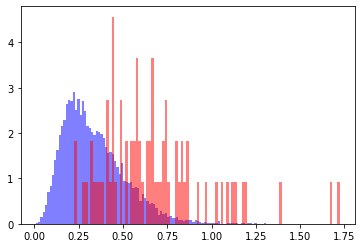

In [36]:
labels,scores,dic= test("NIH")

auc: 0.7625482805053064


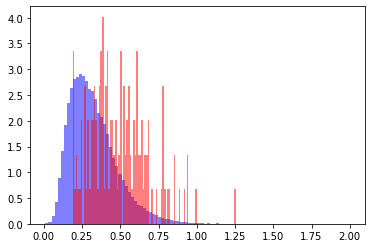

In [178]:
labels,scores,dic= test("JSRT")